# Estimate Impacts of Heat Waves

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import math

# set output path
#os.chdir("")

# importing data from S3
project_dir = ("https://s3groupaustralia.s3.eu-central-1.amazonaws.com/data/impacts+of+heat+waves/")

## Import data

In [2]:
HW = pd.read_csv(project_dir + "Heatwave20002020.csv")
HI = pd.read_csv(project_dir + "Predict_Heatwaves.csv")

In [3]:
HW.head(2)

,Dis No,Year,Disaster Subtype,Entry Criteria,Country,ISO,Region,Continent,Location,Associated Dis,...,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),CPI,gdp,clean energy budget,Unnamed: 33,GNI per capita,Population
0,2000-0382-BGR,2000,Heat wave,SigDis,Bulgaria,BGR,Eastern Europe,Europe,"Sofia, Sofia-city, Stata Zagora, Blagoevgrad, ...",NaN,...,NaN,NaN,NaN,50.0,67.355759,52491.528,0.0,NaN,6270.0,8170172
1,2000-0398-CYP,2000,Heat wave,Affect,Cyprus,CYP,Western Asia,Asia,Nicosia province,NaN,...,400.0,NaN,NaN,NaN,67.355759,14781.223,0.0,NaN,19470.0,943290


In [4]:
HI.head(2)

,Unnamed: 0,Dis No,Country,Year,Month,Rel_Hum,tavg,tmin,tmax,prcp,wspd,heatwave,Region,tavg_F,HI
0,0,2020-0530-GBR,United Kingdom of Great Britain and Northern I...,2000,1,72.0,6.093333,-3.50,12.00,34.763333,21.513333,0.0,Northern Europe,42.968,118.113939
1,1,2020-0530-GBR,United Kingdom of Great Britain and Northern I...,2000,2,77.0,6.863333,-1.94,12.42,61.026667,27.000000,0.0,Northern Europe,44.354,110.667769


In [5]:
HW1 = HW[["Dis No", "Year", "Country", "Start Month", "ISO", "Region", "Continent", "Total Deaths",
              "No Injured", "Total Affected", "CPI", "gdp", "GNI per capita","Population"]]
HW1.columns = ["DisNo", "year", "country", "month", "ISO", "Region", "Continent", "Deaths",
              "NoInjured", "TotalAffected", "CPI","GDP", "GNI","Population"]
HW1.head()

,DisNo,year,country,month,ISO,Region,Continent,Deaths,NoInjured,TotalAffected,CPI,GDP,GNI,Population
0,2000-0382-BGR,2000,Bulgaria,6,BGR,Eastern Europe,Europe,7.0,NaN,NaN,67.355759,52491.528,6270.0,8170172
1,2000-0398-CYP,2000,Cyprus,7,CYP,Western Asia,Asia,5.0,400.0,400.0,67.355759,14781.223,19470.0,943290
2,2000-0379-GRC,2000,Greece,7,GRC,Southern Europe,Europe,27.0,176.0,176.0,67.355759,210979.958,NaN,10805808
3,2000-0324-HRV,2000,Croatia,6,HRV,Southern Europe,Europe,40.0,200.0,200.0,67.355759,47307.968,10390.0,4468302
4,2000-0473-ISR,2000,Israel,7,ISR,Western Asia,Asia,NaN,NaN,NaN,67.355759,157214.843,23440.0,6289000


In [6]:
HW1["country"].replace({"United Kingdom of Great Britain and Northern Ireland (the)": "UK", 
                             "United States of America (the)": "United States",
                            "Macedonia (the former Yugoslav Republic of)": "Macedonia",
                            "Bolivia (Plurinational State of)": "Bolivia",
                            "Sudan (the)": "Sudan"}, inplace=True)
HI["Country"].replace({"United Kingdom of Great Britain and Northern Ireland (the)": "UK", 
                             "United States of America (the)": "United States",
                            "Macedonia (the former Yugoslav Republic of)": "Macedonia",
                            "Bolivia (Plurinational State of)": "Bolivia",
                            "Sudan (the)": "Sudan"}, inplace=True)

/opt/anaconda3/envs/MDA_project/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [7]:
HI.columns

Index(['Unnamed: 0', 'Dis No', 'Country', 'Year', 'Month', 'Rel_Hum', 'tavg',
       'tmin', 'tmax', 'prcp', 'wspd', 'heatwave', 'Region', 'tavg_F', 'HI'],
      dtype='object')

In [8]:
HI.columns = ['Unnamed: 0','DisNo', 'country', 'year', 'month', 'rel_hum', 'tavg',
       'tmin', 'tmax', 'prcp', 'wspd', 'heatwave', 'Region','tavg_F', 'HI']

In [9]:
HW2 = HW1.merge(HI[['country', 'year', 'month', 'rel_hum', 'tavg','HI']], 
                on = ["country", "year", "month"])

In [10]:
HW2.head(2)

,DisNo,year,country,month,ISO,Region,Continent,Deaths,NoInjured,TotalAffected,CPI,GDP,GNI,Population,rel_hum,tavg,HI
0,2000-0382-BGR,2000,Bulgaria,6,BGR,Eastern Europe,Europe,7.0,NaN,NaN,67.355759,52491.528,6270.0,8170172,61.071429,20.831667,69.017057
1,2000-0382-BGR,2000,Bulgaria,6,BGR,Eastern Europe,Europe,7.0,NaN,NaN,67.355759,52491.528,6270.0,8170172,54.500000,20.831667,68.708200


In [11]:
HW3 = HW2.drop_duplicates()

check missing

In [12]:
HW3.isna().sum()

DisNo              0
year               0
country            0
month              0
ISO                0
Region             0
Continent          0
Deaths            59
NoInjured        542
TotalAffected    518
CPI               20
GDP                3
GNI               24
Population         0
rel_hum            0
tavg               4
HI                 4
dtype: int64

In [13]:
#fillna(interpolate)
HW4 = HW3.interpolate(method='polynomial',order = 2)

In [14]:
HW5 = HW4.dropna()
HW5 = HW5.reset_index()

In [15]:
result = HW5.columns
HW5.head(10)

,index,DisNo,year,country,month,ISO,Region,Continent,Deaths,NoInjured,TotalAffected,CPI,GDP,GNI,Population,rel_hum,tavg,HI
0,2,2000-0398-CYP,2000,Cyprus,7,CYP,Western Asia,Asia,5.000000,400.000000,400.000000,67.355759,14781.223000,19470.000000,943290,55.666667,28.525000,85.468281
1,3,2000-0398-CYP,2000,Cyprus,7,CYP,Western Asia,Asia,5.000000,400.000000,400.000000,67.355759,14781.223000,19470.000000,943290,88.000000,28.525000,95.278556
2,4,2000-0379-GRC,2000,Greece,7,GRC,Southern Europe,Europe,27.000000,176.000000,176.000000,67.355759,210979.958000,16644.849581,10805808,64.769231,26.260000,81.368376
3,5,2000-0379-GRC,2000,Greece,7,GRC,Southern Europe,Europe,27.000000,176.000000,176.000000,67.355759,210979.958000,13557.647705,10805808,60.857143,26.260000,81.042498
4,6,2000-0324-HRV,2000,Croatia,6,HRV,Southern Europe,Europe,40.000000,200.000000,200.000000,67.355759,47307.968000,10390.000000,4468302,64.190476,22.460000,72.387752
5,7,2000-0324-HRV,2000,Croatia,6,HRV,Southern Europe,Europe,40.000000,200.000000,200.000000,67.355759,47307.968000,10390.000000,4468302,66.000000,22.460000,72.472800
6,8,2000-0473-ISR,2000,Israel,7,ISR,Western Asia,Asia,36.096863,120.500362,120.500362,67.355759,157214.843000,23440.000000,6289000,64.333333,28.638889,87.907317
7,9,2000-0471-JOR,2000,Jordan,7,JOR,Western Asia,Asia,30.834503,12.000000,12.000000,67.355759,846.042440,6010.000000,5122493,52.000000,26.256456,75.995444
8,10,2000-0487-MAR,2000,Morocco,8,MAR,Northern Africa,Africa,26.154891,-65.506858,-65.506858,67.355759,38857.251340,3510.000000,28793679,83.000000,24.866667,78.037000
9,11,2000-0351-PAK,2000,Pakistan,6,PAK,Southern Asia,Asia,24.000000,-112.020213,-112.020213,67.355759,8201.774342,2560.000000,142343578,81.000000,33.225595,121.209139


## Data preprocess

check correlation

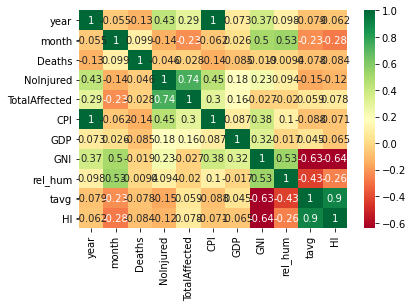

In [16]:
g=sns.heatmap(HW5[['DisNo', 'year', 'country', 'month', 'ISO', 'Region', 'Continent',
       'Deaths', 'NoInjured', 'TotalAffected', 'CPI', 'GDP', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']].corr(),cmap='RdYlGn',annot=True)

In [17]:
#choose variables for model
HW6 = HW5[['year', 'country', 'month', 'Region', 'Continent',
       'Deaths', 'NoInjured', 'TotalAffected', 'CPI', 'GDP', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']]

process category variables

In [18]:
#encode category variables
encoder1= LabelEncoder().fit(HW6["country"])
encoder3= LabelEncoder().fit(HW6["Region"])
encoder4= LabelEncoder().fit(HW6["Continent"])
HW6["country"] = encoder1.transform(HW6["country"])
HW6["Region"] = encoder3.transform(HW6["Region"])
HW6["Continent"] = encoder4.transform(HW6["Continent"])
HW6.head(3)

<ipython-input-18-dc0e2d4e7f4c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HW6["country"] = encoder1.transform(HW6["country"])
<ipython-input-18-dc0e2d4e7f4c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HW6["Region"] = encoder3.transform(HW6["Region"])
<ipython-input-18-dc0e2d4e7f4c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,year,country,month,Region,Continent,Deaths,NoInjured,TotalAffected,CPI,GDP,GNI,Population,rel_hum,tavg,HI
0,2000,14,7,11,2,5.0,400.0,400.0,67.355759,14781.223,19470.000000,943290,55.666667,28.525,85.468281
1,2000,14,7,11,2,5.0,400.0,400.0,67.355759,14781.223,19470.000000,943290,88.000000,28.525,95.278556
2,2000,19,7,9,3,27.0,176.0,176.0,67.355759,210979.958,16644.849581,10805808,64.769231,26.260,81.368376


In [19]:
HW6 = HW6.astype('int') 

## Model Building

In [20]:
def HW_model(model, X, y):
    np.random.seed(123)
    model.fit( X, y)
    pred_y = model.predict(X)
    kf = KFold(n_splits= 5)
    RMSE = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        pred_y = model.predict(X_test)
        RMSE.append(math.sqrt(mean_squared_error(y_test, pred_y)))
        print('RMSE:',math.sqrt(mean_squared_error(y_test, pred_y)))
    print("Cross-Validation RMSE {0}".format(np.mean(RMSE)))

### CPI as target

In [21]:
# predict cpi
y1 = HW6['CPI']
X1 = HW6[['year', 'country', 'month', 'Region', 'Continent',
       'Deaths', 'NoInjured', 'TotalAffected', 'GDP', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']]
# RandomForest
print('---------------')
model1 = RandomForestClassifier(n_estimators=200)
HW_model(model1, X1, y1 )
#Decision Tree
print('---------------')
model2 = DecisionTreeClassifier()
HW_model(model2, X1, y1 )
#SVM
print('---------------')
model3 = SVC()
HW_model(model3, X1, y1)
#Xgboost
print('---------------')
data_dmatrix = xgb.DMatrix(data=HW6[['year', 'country', 'month', 'Region', 'Continent',
       'Deaths', 'NoInjured', 'TotalAffected', 'GDP', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']],label=HW6["CPI"])

params = {'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=1)
print((cv_results["test-rmse-mean"]).tail(1))

---------------
RMSE: 6.944385487278076
RMSE: 6.3759753155489705
RMSE: 7.090282705473556
RMSE: 8.495768487416592
RMSE: 6.359115989222367
Cross-Validation RMSE 7.053105596987912
---------------
RMSE: 3.048363004434137
RMSE: 2.5714285714285716
RMSE: 3.347249861102852
RMSE: 1.3674293450480832
RMSE: 1.5170266520446167
Cross-Validation RMSE 2.3702994868116525
---------------
RMSE: 24.974681056573093
RMSE: 18.64509200251672
RMSE: 10.557262065181728
RMSE: 19.743041083705336
RMSE: 9.366582979525072
Cross-Validation RMSE 16.65733183750039
---------------
9    30.140162
Name: test-rmse-mean, dtype: float64


In [22]:
#model2 is better
#Create a series with feature importances:
np.random.seed(123)
model2 = DecisionTreeClassifier()
HW_model(model2, X1, y1 )
featimp = pd.Series(model2.feature_importances_, index=['year', 'country', 'month', 'Region', 'Continent',
       'Deaths', 'NoInjured', 'TotalAffected', 'GDP', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']).sort_values(ascending=False)
print(featimp)

RMSE: 3.048363004434137
RMSE: 2.5714285714285716
RMSE: 3.347249861102852
RMSE: 1.3674293450480832
RMSE: 1.5170266520446167
Cross-Validation RMSE 2.3702994868116525
year             0.910285
NoInjured        0.042340
HI               0.025394
Deaths           0.021981
country          0.000000
month            0.000000
Region           0.000000
Continent        0.000000
TotalAffected    0.000000
GDP              0.000000
GNI              0.000000
Population       0.000000
rel_hum          0.000000
tavg             0.000000
dtype: float64


### GDP as target

In [23]:
# predict gdp
y1 = HW6['GDP']
X1 = HW6[['year', 'country', 'month', 'Region', 'Continent',
       'Deaths', 'NoInjured', 'TotalAffected', 'GNI', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']]
# RandomForest
print('---------------')
model1 = RandomForestClassifier(n_estimators=200)
HW_model(model1, X1, y1 )
#Decision Tree
print('---------------')
model2 = DecisionTreeClassifier()
HW_model(model2, X1, y1 )
#SVM
print('---------------')
model3 = SVC()
HW_model(model3, X1, y1)
#Xgboost
print('---------------')
data_dmatrix = xgb.DMatrix(data=HW6[['year', 'country', 'month', 'Region', 'Continent',
       'Deaths', 'NoInjured', 'TotalAffected', 'CPI', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']],label=HW6["GDP"])

params = {'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=1)
print((cv_results["test-rmse-mean"]).tail(1))

---------------
RMSE: 2016950.3166523548
RMSE: 1250142.993550335
RMSE: 3128036.588391963
RMSE: 2443922.6166234105
RMSE: 4286119.842168846
Cross-Validation RMSE 2625034.471477382
---------------
RMSE: 4429423.192736074
RMSE: 1405108.9484001214
RMSE: 2856062.5547914235
RMSE: 1913349.412206541
RMSE: 4514264.7484704545
Cross-Validation RMSE 3023641.771320923
---------------
RMSE: 3997492.343018709
RMSE: 4079532.7024853607
RMSE: 3826587.931849969
RMSE: 4141297.9306070227
RMSE: 3661778.1464373395
Cross-Validation RMSE 3941337.8108796803
---------------
9    2245730.125
Name: test-rmse-mean, dtype: float64


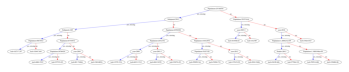

In [24]:
#model 4 is better
#plot
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig('GDP1')
plt.show()

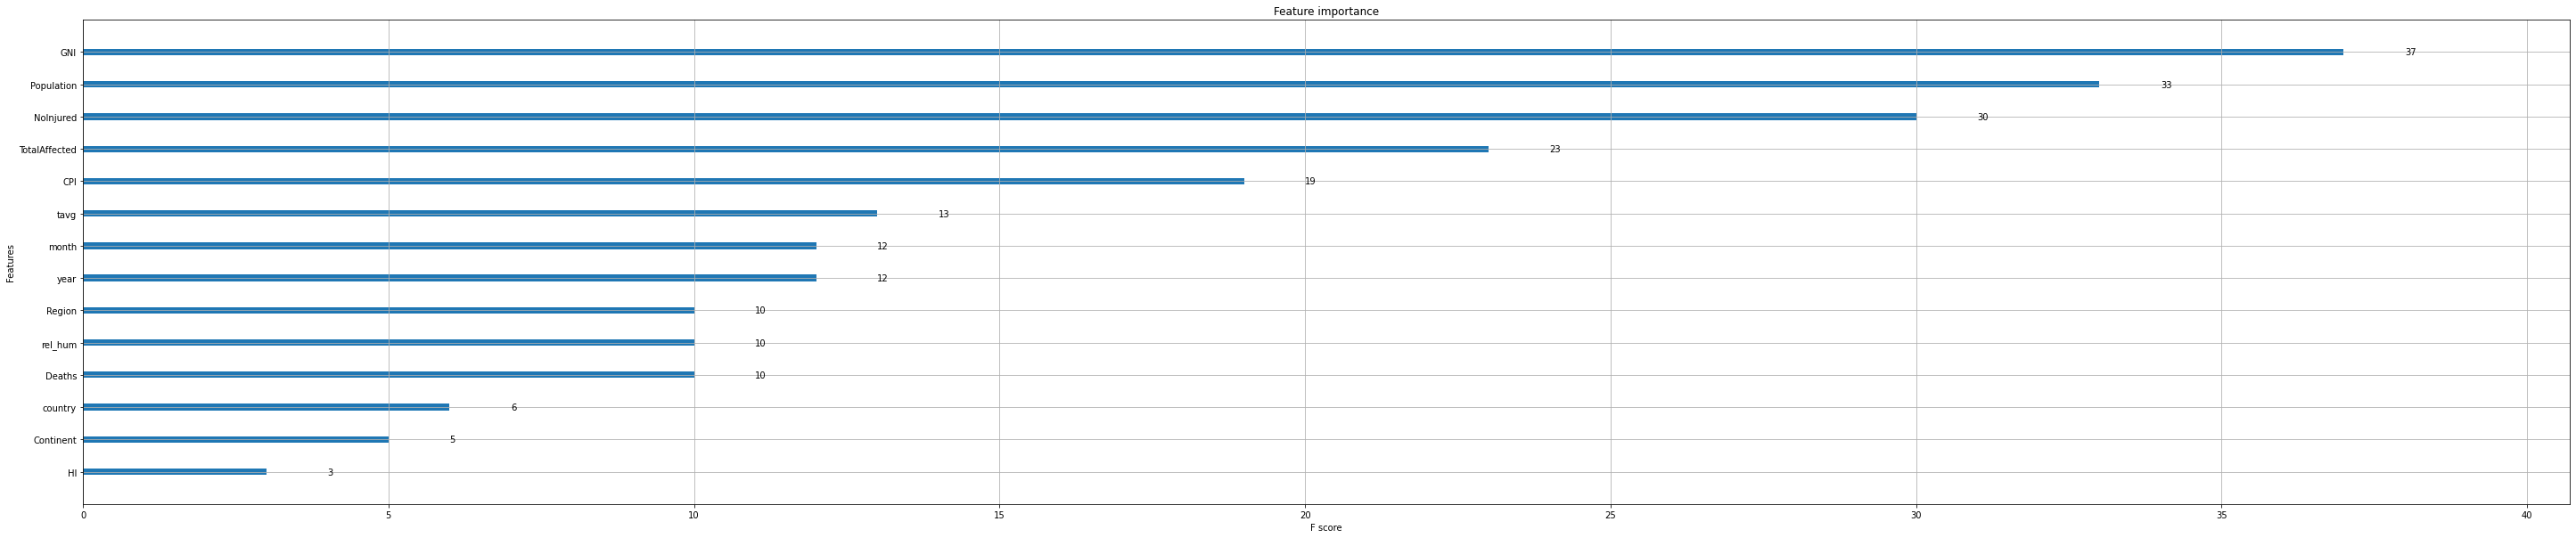

In [25]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig('GDP2')
plt.show()

### Death as target

In [26]:
# predict gdp
y1 = HW6['Deaths']
X1 = HW6[['year', 'country', 'month', 'Region', 'Continent',
       'GDP', 'NoInjured', 'TotalAffected', 'GNI', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']]
# RandomForest
print('---------------')
model1 = RandomForestClassifier(n_estimators=200)
HW_model(model1, X1, y1 )
#Decision Tree
print('---------------')
model2 = DecisionTreeClassifier()
HW_model(model2, X1, y1 )
#SVM
print('---------------')
model3 = SVC()
HW_model(model3, X1, y1)
#Xgboost
print('---------------')
data_dmatrix = xgb.DMatrix(data=HW6[['year', 'country', 'month', 'Region', 'Continent',
       'GDP', 'NoInjured', 'TotalAffected', 'CPI', 'GNI',
       'Population', 'rel_hum', 'tavg', 'HI']],label=HW6["Deaths"])

params = {'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=1)
print((cv_results["test-rmse-mean"]).tail(1))

---------------
RMSE: 8737.35290398113
RMSE: 6532.808512517759
RMSE: 6699.407000866965
RMSE: 1579.73553361453
RMSE: 977.4670158748518
Cross-Validation RMSE 4905.354193371047
---------------
RMSE: 6100.867632619831
RMSE: 2838.320498411108
RMSE: 6471.8527764886785
RMSE: 874.8337572017475
RMSE: 1031.447025180365
Cross-Validation RMSE 3463.4643379803465
---------------
RMSE: 6247.21006682564
RMSE: 584.4826365093769
RMSE: 6549.228905642511
RMSE: 1030.0161290132291
RMSE: 275.247099445979
Cross-Validation RMSE 2937.236967487347
---------------
9    2220.535572
Name: test-rmse-mean, dtype: float64


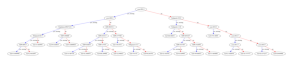

In [27]:
#model 4 is better
#plot
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig('death1')
plt.show()

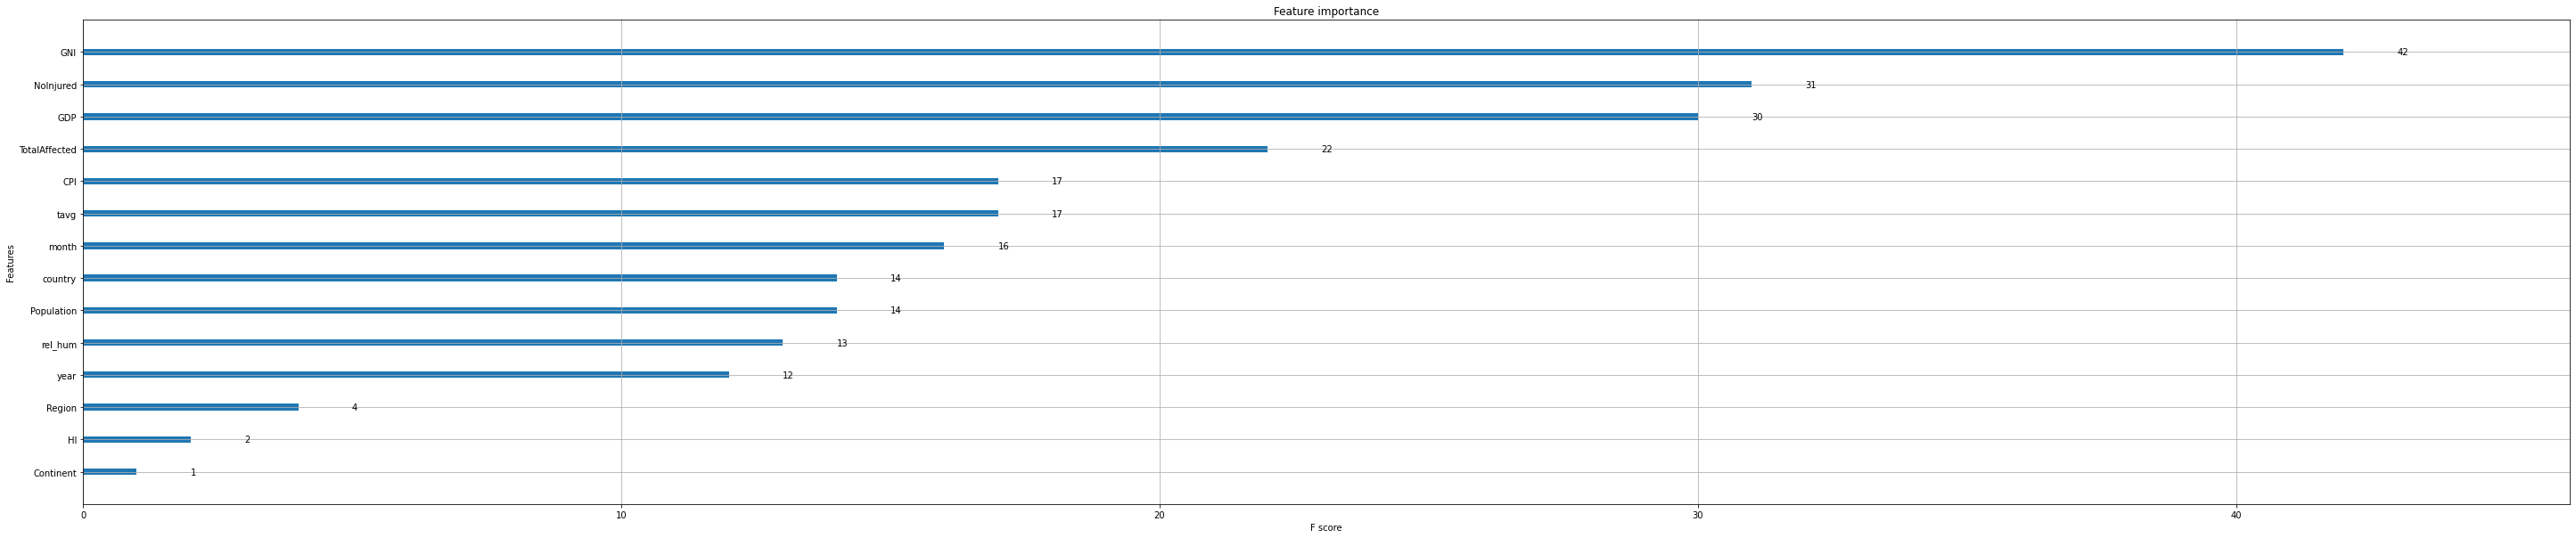

In [28]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig('death2')
plt.show()